In [1]:
import torch.nn as nn
import torch
import numpy as np
from spline import *
from utils import *
import matplotlib.pyplot as plt

from KAN import MyKAN
import spline

In [2]:
# create dataset f(x,y) = exp(sin(pi*x)+y^2)
f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
dataset = create_dataset(f, n_var=2)
dataset['train_input'].shape, dataset['train_label'].shape, dataset['test_input'].shape, dataset['test_label'].shape

X_train, y_train, X_test, y_test = dataset['train_input'], dataset['train_label'], dataset['test_input'], dataset['test_label']

In [7]:
# creating a KAN layer from scratch
class MyKANLayer(nn.Module):

    def __init__(self, in_dim, out_dim, grid, degree=3, approx_type="taylor", grid_range=[-1, 1], device='cpu'):
        super(MyKANLayer, self).__init__()

        # initiliaze variables about the layer
        self.size = size = out_dim * in_dim
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.degree = degree
        self.grid_range = grid_range
        self.cache = None
        self.approx_type = approx_type

        # The spline function requires three parameters: knots, coeff, and degree
        # knots: the grid points for the spline
        # self.knots = nn.Parameter(torch.linspace(grid_range[0], grid_range[1], steps=grid + 1, device=device).repeat(size, 1)).requires_grad_(False)
        self.knots = nn.Parameter(torch.linspace(grid_range[0], grid_range[1], steps=grid + 1, device=device).repeat(size, 1), requires_grad=False)

        # coeff: the coefficients for the spline - these are learnable!
        # I am wrapping them in a parameter since that is what they are
        # 
        self.coeff = nn.Parameter(0.1 * torch.randn(size, grid + degree if approx_type == "spline" else 1 + degree, device=device), requires_grad=True)


    def forward(self, x):

        # we process data in batches!
        batch_size = x.shape[0]

        # we need to repeat the input for each spline function
        # x.shape = (size, batch_size)
        x = x.transpose(0, 1).repeat(self.out_dim, 1)

        # store the input for later
        self.cache = x

        # store the output of the spline functions
        out = torch.zeros(self.size, batch_size)
        
        knots = self.knots
        coeff = self.coeff

        # print('x shape: ', x.shape)
        # print('knots shape: ', knots.shape)
        # print('coeff shape: ', coeff.shape)

        spline_values = spline.coef2curve(x, knots, coeff, self.degree)
        out = spline_values
        # print('out shape: ', out.shape)

        # # loop through all the spline functions, and apply them to a single element for the whole batch
        # # TODO: see if we can vectorize this
        # for i in range(self.size):
        #     taylor_values = self.evaluate_taylor_series(x[i], coeff, self.degree)
        #     out[i] = taylor_values


        # reshape the output to be of shape (out_dim, in_dim, batch_size)
        # then we sum it as part of the algorithm
        # then we transpose it so subsequent layers can use it
        y = out.reshape(self.out_dim, self.in_dim, batch_size).sum(dim=1).transpose(0, 1)

        return y
    

    def evaluate_taylor_series(self, x, coeff, degree):
        # Evaluate the Taylor series of x using the coefficients
        exp = torch.arange(degree+1).view(1, -1).repeat(x.shape[0], 1)
        powed = torch.pow(x.view(-1, 1), exp)
        
        return torch.sum(coeff * powed, dim=1)


    # If we want to plot the spline curves of a layer
    def plot(self):
        # Plot the spline functions (optional)
        points = torch.linspace(self.grid_range[0], self.grid_range[1], 100)

        if self.approx_type == "spline":
            xs = points.repeat(self.size, 1)
            y = spline.coef2curve(xs, self.knots, self.coeff, self.degree).detach().cpu().numpy()
            for i in range(self.size):
                plt.plot(xs[i], y[i])
        else:
            for i in range(self.size):
                y = self.evaluate_taylor_series(points, coeff=self.coeff[i], degree=self.degree).detach().cpu().numpy()
                plt.plot(points, y, label=f'B_{i,3}(points)')
            
        plt.title('Cubic B-spline Basis Functions')
        plt.xlabel('x')
        plt.ylabel('B_{i,3}(points)')
        plt.legend()
        plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


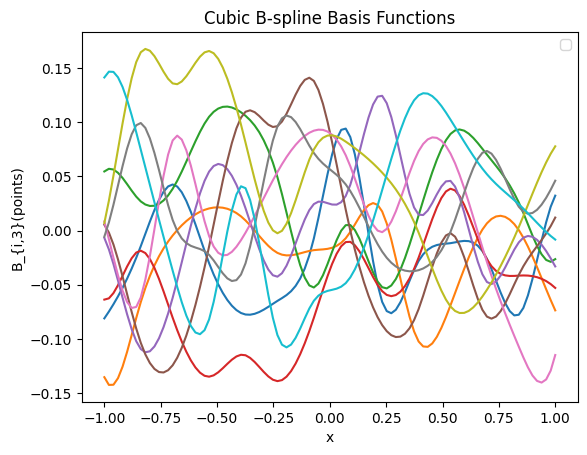

In [8]:
# Testing the layer
layer = MyKANLayer(in_dim=2, out_dim=5, grid=13, approx_type="spline", degree=3)

out = layer(dataset['train_input'][:2])
out
layer.plot()

In [9]:
# test the KAN here
model = MyKAN(width=[2, 1, 1], grid=10, degree=3, approx_type="spline", device='cpu')

out = model(dataset['train_input'][:10])
out

tensor([[-0.0110],
        [ 0.0414],
        [ 0.0256],
        [-0.0048],
        [ 0.0165],
        [ 0.0224],
        [ 0.0212],
        [ 0.0235],
        [ 0.0180],
        [-0.0224]], grad_fn=<TransposeBackward0>)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


xs shape:  torch.Size([2, 100])
y shape:  (2, 100)


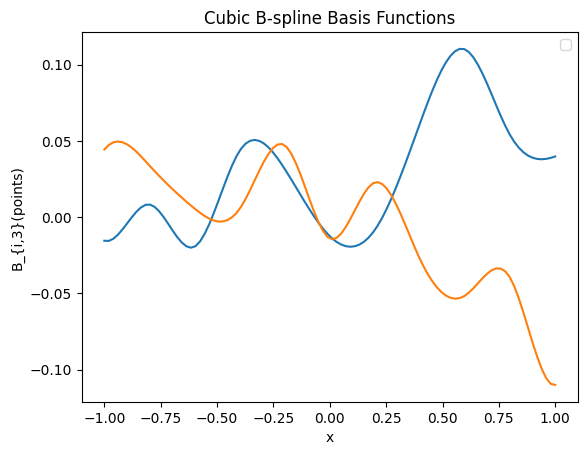

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


xs shape:  torch.Size([1, 100])
y shape:  (1, 100)


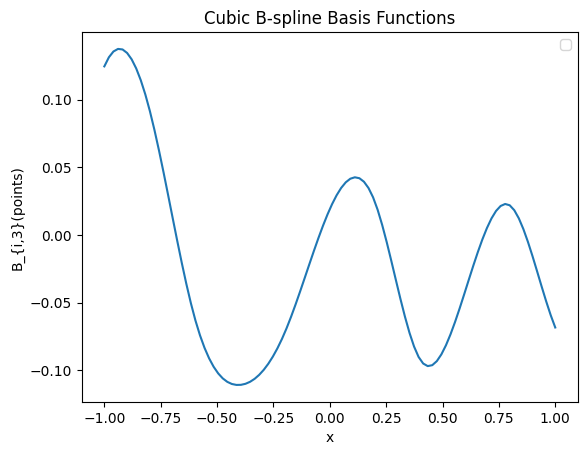

Epoch [1000/20000], Loss: 1.5873
Epoch [2000/20000], Loss: 0.5129
Epoch [3000/20000], Loss: 0.2410
Epoch [4000/20000], Loss: 0.1225
Epoch [5000/20000], Loss: 0.0649
Epoch [6000/20000], Loss: 0.0352
Epoch [7000/20000], Loss: 0.0195
Epoch [8000/20000], Loss: 0.0109
Epoch [9000/20000], Loss: 0.0061


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Epoch [10000/20000], Loss: 0.0033
xs shape:  torch.Size([2, 100])
y shape:  (2, 100)


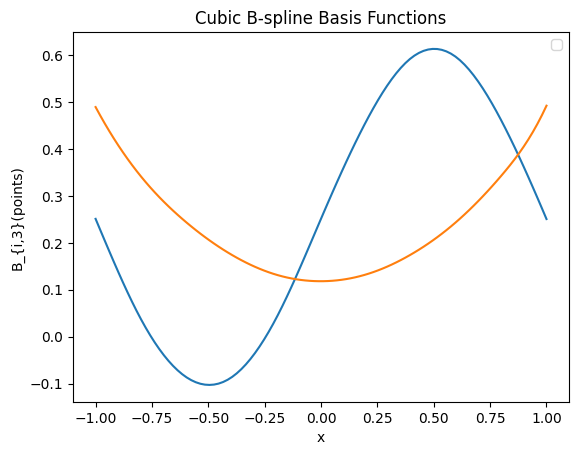

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


xs shape:  torch.Size([1, 100])
y shape:  (1, 100)


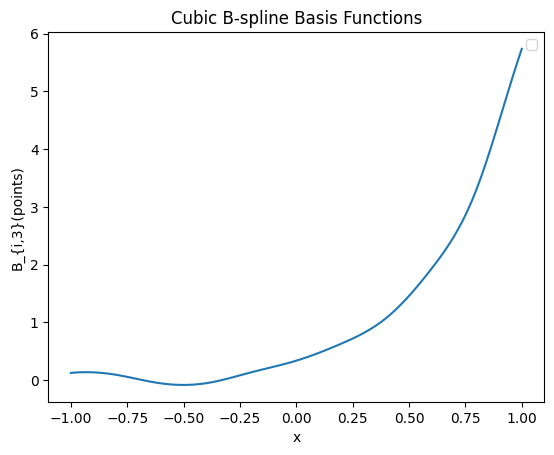

Epoch [11000/20000], Loss: 0.0017
Epoch [12000/20000], Loss: 0.0008
Epoch [13000/20000], Loss: 0.0003
Epoch [14000/20000], Loss: 0.0001
Epoch [15000/20000], Loss: 0.0000
Epoch [16000/20000], Loss: 0.0000
Epoch [17000/20000], Loss: 0.0000
Epoch [18000/20000], Loss: 0.0000
Epoch [19000/20000], Loss: 0.0000


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Epoch [20000/20000], Loss: 0.0000
xs shape:  torch.Size([2, 100])
y shape:  (2, 100)


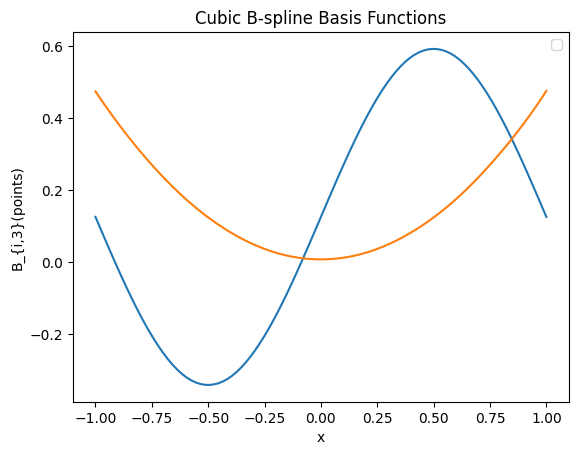

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


xs shape:  torch.Size([1, 100])
y shape:  (1, 100)


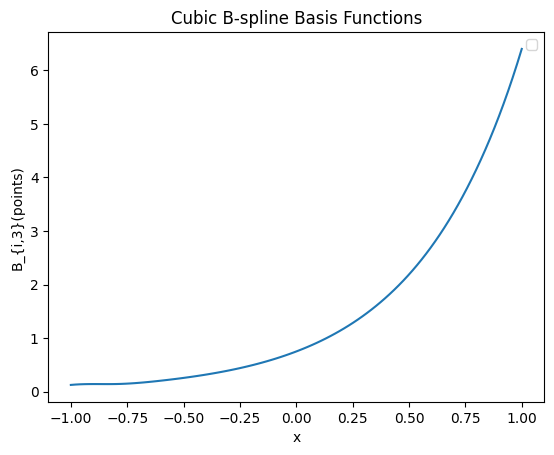

Test Loss: 0.0000


In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# MSE Loss
criterion = nn.MSELoss()



num_epochs = 20000
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode

    optimizer.zero_grad()  # Zero the gradients

    outputs = model(X_train)  # Forward pass
    loss = criterion(outputs, y_train)  # Compute the loss

    # does not solve issue, because of this error does not go down
    # loss = torch.autograd.Variable(loss, requires_grad = True)

    loss.backward()  # Backward pass (compute gradients)
    optimizer.step()  # Update the parameters

    if (epoch+1) % 1000 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    
    if (epoch+1) % 10000 == 0 or epoch == 0:
        model.plot()

# After training, you can evaluate the model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    test_outputs = model(X_test)  # Forward pass on the training data
    test_loss = criterion(test_outputs, y_test)  # Compute the loss
    print(f'Test Loss: {test_loss.item():.4f}')